In [22]:
import torch
torch.manual_seed(42)
from ExplanationEvaluation.models.GNN_paper import NodeGCN as GNN_NodeGCN
from torch_geometric.nn import GNNExplainer
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from ExplanationEvaluation.datasets.dataset_loaders import load_dataset
import numpy as np

# Original Dataset

First, we need to load the dataset that we are interested in explaining. To be able to explain the decision of a model we only need the graphs itself (including the features), but because we also want to plot the explanations later, we also need the node labels to color them.

It's important to note here that the GNNExplainer requires the graphs to be represented by edge index and not an adjacency matrix. 

In [3]:
edge_index, x, labels, train_mask, val_mask, test_mask = load_dataset("Twitch")
labels = torch.tensor(labels)

Loading Twitch dataset


<BarContainer object of 2 artists>

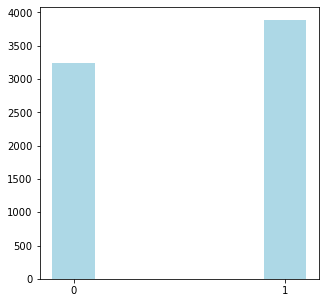

In [4]:
rcParams['figure.figsize'] = 5, 5
df = pd.DataFrame(labels, columns=["explicit_language"])
plt.xticks([0,1])
plt.bar(df['explicit_language'].value_counts().keys(), df['explicit_language'].value_counts().values, color="lightblue", width=0.2)


## GNNExplainer

Second, we load the model that we wish to explain. For the model to work with the explainers there are a few restrictions. For an example, we recommend to look at the file: models/GNN_paper.py

For the GNNExplainer, the restrictions are a bit more serious. Specifically, it needs the model to be implemented using the PyTorch-Geometric library. This is because for the GNNExplainer the mask is directly inserted into the model instead of using the edge weights.


In [5]:
# Overwrite these models with your own if you want to
model = GNN_NodeGCN(128, 2)

path = "./ExplanationEvaluation/models/pretrained/GNN/Twitch/best_model"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

As this stage we can finally start to construct the explainer itself. While we are obviously going to use the GNNExplainer here, it should make no difference which explainer is chosen for the past or upcomming steps. 

The only small thing we need to be careful with is the initialization of the explainers. To findout exactly which parameters are available for this we suggest that you have a look at the code. For now it is enough to know that the explainer takes the model to be explainer, the number of epochs you wish to train the explainer for and the return type denotes the type of output from explainer
Valid inputs are 
1. "log_prob" (the model returns the logarithm of probabilities)
2. "prob" (the model returns probabilities)
3. "raw" (the model returns raw scores)
4. `"regression" (the model returns scalars).

        (default: "log_prob")

In [6]:
explainer = GNNExplainer(model, epochs=200, return_type="log_prob", num_hops=2)

We have our explainer ready and now we can start explaining the predictions of our GNN model

In [7]:
# Consider any node within 
# Check node 7, 1000 for quicker results
idx = 1505
node_features_mask, edge_mask = explainer.explain_node(idx, x, edge_index)

Explain node 1505: 100%|██████████| 200/200 [00:00<00:00, 584.40it/s]


In [8]:
print(edge_mask.argwhere().shape)
print(node_features_mask.shape)

torch.Size([49, 1])
torch.Size([128])


In [9]:
print("Features of explained node : ", x[idx])
print("ground truth : ", labels[idx].numpy())

Features of explained node :  tensor([-0.2367, -0.2307, -0.1605, -0.2172, -0.2124, -0.2038, -0.5386, -0.4115,
        -0.1622, -0.2234, -0.2462, -0.3459, -0.1957, -0.2217, -0.4750, -0.2006,
        -0.4221, -0.2882,  2.0305, -0.2263,  4.2392, -0.2192, -0.2268, -0.2027,
        -0.9605, -0.1771, -0.2800, -0.2361, -0.2232, -0.2057, -0.3251, -0.2093,
        -0.2701, -0.2341, -0.5585, -0.2432, -0.1553, -0.3480, -0.3727, -0.4935,
        -0.2020, -0.2183, -0.4782, -0.2137, -0.2263, -0.1552, -0.4842,  1.9319,
        -0.2193, -0.2209, -0.1656, -0.2100,  1.5191, -0.2943,  4.0248, -0.5346,
        -0.2680, -0.2187, -0.2572, -0.2951, -0.2064, -0.1906, -0.2112, -0.3113,
        -0.2045, -0.2656,  3.1450, -0.2798, -0.2334, -0.1445, -0.2650, -0.4506,
        -0.2131, -0.2528,  2.2490, -0.2046, -0.3081, -0.4853, -0.2181, -0.2549,
         2.8362, -0.1695, -0.3224, -0.2822, -0.3074, -0.2185, -0.2841, -0.4582,
        -0.1638, -0.2788, -0.2172, -0.5902,  1.4280, -0.1791, -0.1836, -0.1665,
        -0

## Visualization
    Now visualize it

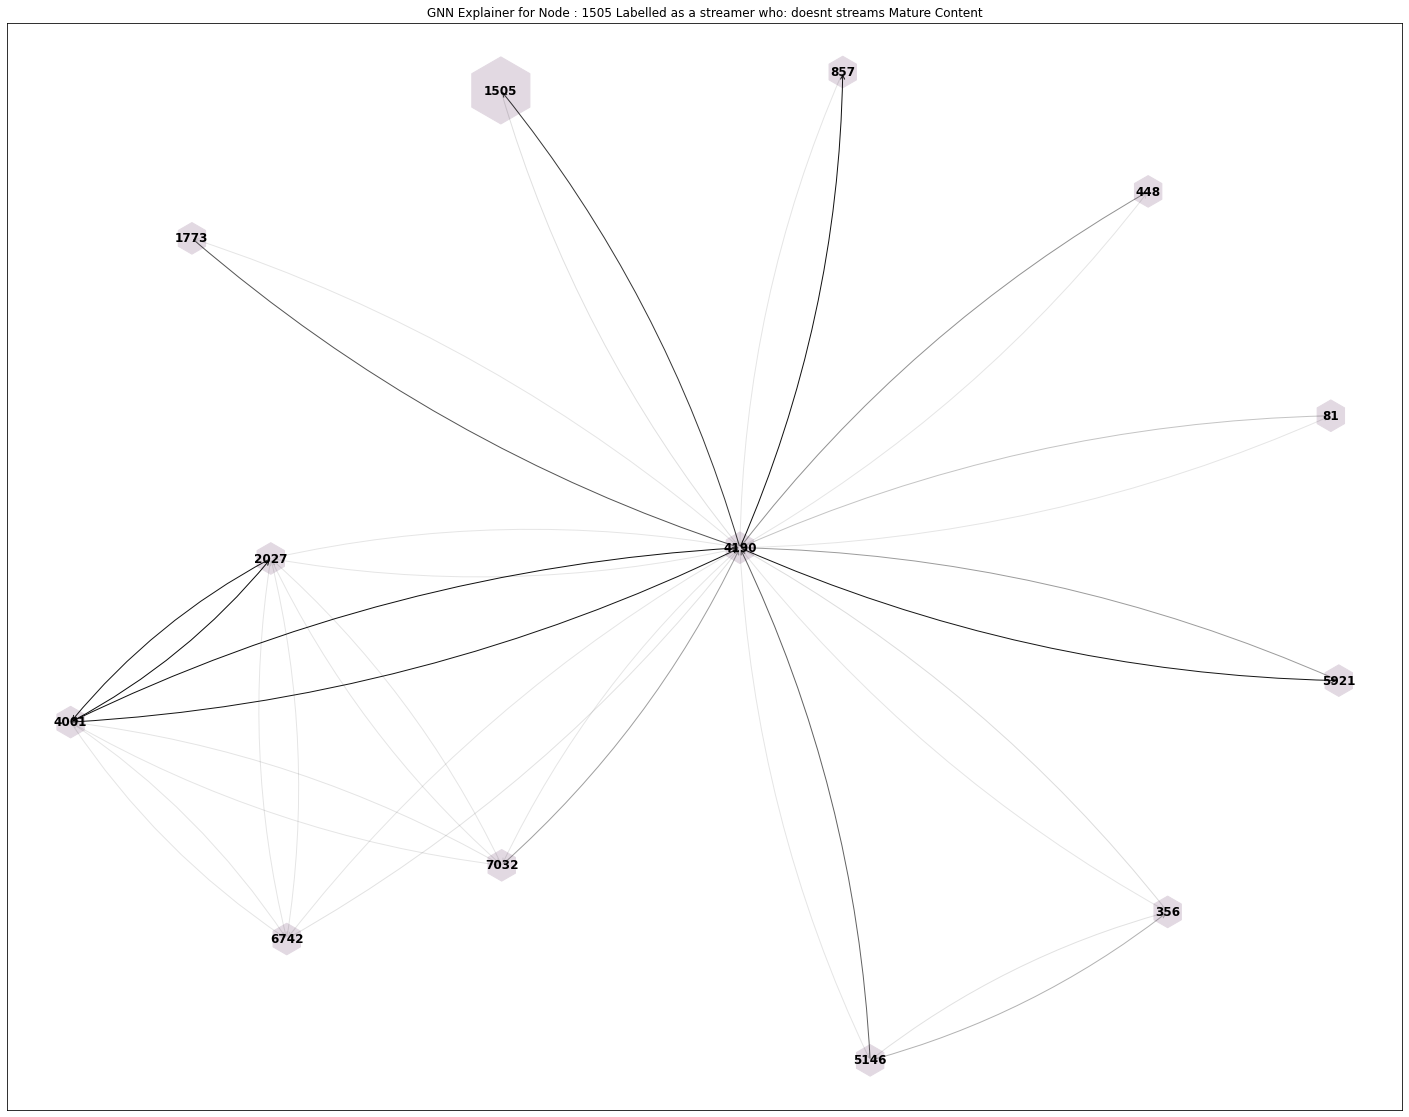

In [10]:
rcParams['figure.figsize'] = 25, 20
ax, G = explainer.visualize_subgraph(idx, edge_index, edge_mask, y=labels, cmap="twilight", node_shape="h", font_size= 12, font_weight="bold")
title = f"GNN Explainer for Node : {idx} Labelled as a streamer who: {'doesn''t ' if labels[idx].numpy() == 1 else ''}streams Mature Content"
plt.title(title, )
plt.show()

<center><i>Perfect! We can clearly see the why the particular node was predicted as a user which streams mature content or a user who does not stream mature content</i></center>

## Metrics

    Top Features

<AxesSubplot:title={'center':'Top 10 features explaining Node Classification'}, xlabel='Game Index Played by Twitch User', ylabel='Importance'>

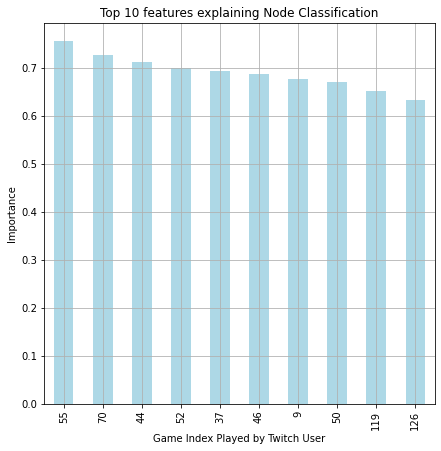

In [11]:
feat_importances = pd.Series(node_features_mask.numpy())
feat_importances.nlargest(10).plot(kind='bar',figsize=(7,7), grid=True,
ylabel='Importance',xlabel='Game Index Played by Twitch User',
title='Top 10 features explaining Node Classification',
color="lightblue"
)

    ROC AUC Score

In [12]:
df = pd.DataFrame()

# Model predictions
out = torch.sigmoid(model(x, edge_index))
df["preds"] = out[test_mask].argmax(dim=1).numpy()

# Groundtruth
df["gt"] = labels[test_mask].squeeze()

print("Test ROC AUC: ", roc_auc_score(df["gt"], df["preds"]))

Test ROC AUC:  0.6939229979500232


<u><center>Test ROC AUC Obtained for Twitch Dataset is <b> 0.6939</center></b></u>


    Confusion Matrix

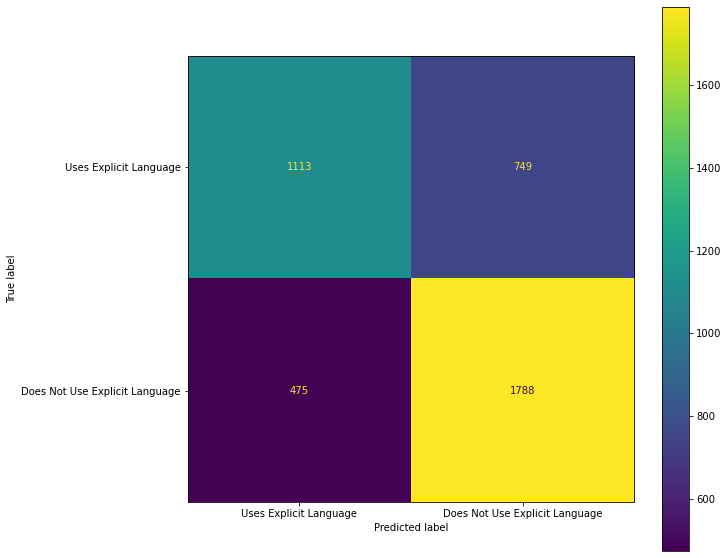

In [28]:
cm = confusion_matrix(df["gt"], df["preds"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Uses Explicit Language", "Does Not Use Explicit Language"])
rcParams['figure.figsize'] = 10, 10
disp.plot()

    Classification Report

In [24]:
print(classification_report(df["gt"], df["preds"], target_names=["Uses Explicit Language", "Does Not Use Explicit Language"]))

                                precision    recall  f1-score   support

        Uses Explicit Language       0.70      0.60      0.65      1862
Does Not Use Explicit Language       0.70      0.79      0.75      2263

                      accuracy                           0.70      4125
                     macro avg       0.70      0.69      0.70      4125
                  weighted avg       0.70      0.70      0.70      4125

